In [23]:
import numpy as np
from matplotlib import pyplot as plt
# use cool font
plt.rc('font', family='Arial', size=12)
from solair.constants import constants
from solair.simulation import DynamicLength
from solair.cost import calculate_total_cost_air_cooler
from solair.design import Tube

def get_cost(x, with_sim=True):
    tube_in_diameter = x[0]
    tube_out_diameter = tube_in_diameter * x[1]
    fin_in_diameter = tube_out_diameter  * x[2]
    fin_out_diameter = fin_in_diameter * x[3]
    fin_pitch = x[4]
    fin_thickness = fin_pitch * x[5]

    tube = Tube(
    tube_in_diameter=tube_in_diameter,
    tube_out_diameter=tube_out_diameter,
    fin_in_diameter=fin_in_diameter,
    fin_out_diameter=fin_out_diameter,
    fin_pitch=fin_pitch,
    fin_thickness=fin_thickness,
    )
    if with_sim:
        sim = DynamicLength(tube, verbose=0, n_rows=4, n_sub_shx=1, fast=False,)
        sim.run()
        tube.n_segments = sim.n_segments
    # value = sim.results["t_co2"][-1][-1] # minimize the last temperature of the last tube
    cost = calculate_total_cost_air_cooler(
    constants.rho_steel,
    constants.cost_steel,
    constants.rho_alu,
    constants.cost_alu,
    25,
    0.05,
    tube,
    )
    return cost, tube

# load previuos fit
X20, fX20 = np.load("init_temp20.npz").values()
X25, fX25 = np.load("init_temp25.npz").values()
X30, fX30 = np.load("init_temp30.npz").values()
X35, fX35 = np.load("init_temp35.npz").values()



TypeError: float() argument must be a string or a real number, not 'Tube'

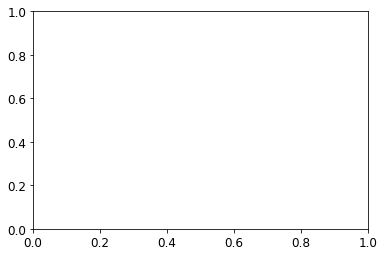

In [25]:
cost_best20 = get_cost(X20[fX20.argmin()])
cost_best25 = get_cost(X25[fX25.argmin()])
cost_best30 = get_cost(X30[fX30.argmin()])
cost_best35 = get_cost(X35[fX35.argmin()])

temperatures = [20,25,30,35]



In [ ]:
plt.figure()
plt.plot(temperatures,[cost_best20,cost_best25, cost_best30, cost_best35])
plt.xlabel('Temperature')
plt.ylabel('')

Text(0.5, 1.0, 'Fin thickness')

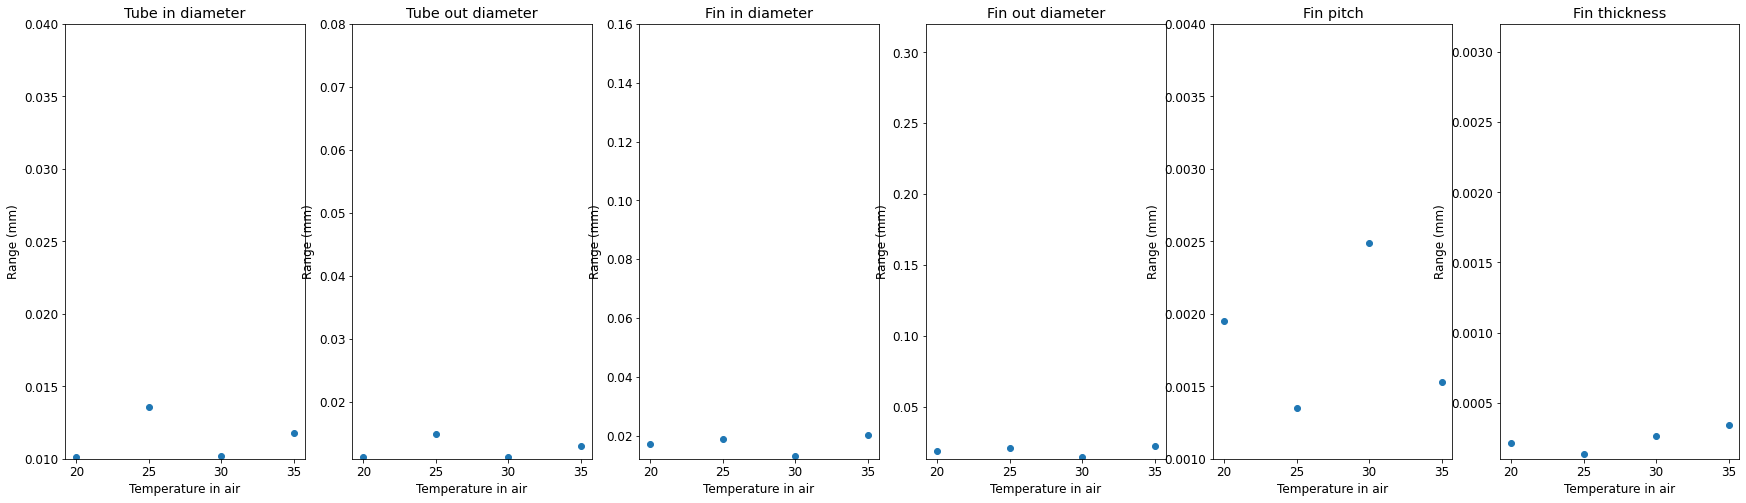

In [18]:
temperatures = [20,25,30,35]
x_best20 = np.reshape(X20[fX20.argmin()],[1,6])
x_best25 = np.reshape(X25[fX25.argmin()],[1,6])
x_best30 = np.reshape(X30[fX30.argmin()],[1,6])
x_best35 = np.reshape(X35[fX35.argmin()],[1,6])

x_best = np.concatenate((x_best20, x_best25, x_best30,x_best35), axis=0)
tube_in_diameter_best  = x_best[:,0],
tube_out_diameter_best = np.multiply(x_best[:,1],tube_in_diameter_best)
fin_in_diameter_best = np.multiply(x_best[:,2],tube_out_diameter_best)
fin_out_diameter_best = np.multiply(x_best[:,3],fin_in_diameter_best)
fin_pitch_best = x_best[:,4]
fin_thickness_best = np.multiply(x_best[:,5],fin_pitch_best)

lb_tid =20e-3 - 10e-3
up_tid = 20e-3 + 20e-3
lb = [lb_tid, 1.1*lb_tid, 1.1**2*lb_tid,1.1**3*lb_tid,1e-3,0.1*1e-3]
ub = [up_tid, 2*up_tid, 2*2*up_tid,2**3*up_tid, 4e-3,0.8*4e-3]

fig, ax = plt.subplots(1, 6, figsize=(6*5,8))
ax[0].scatter(temperatures,tube_in_diameter_best)
ax[0].set_ylim(lb[0],ub[0])
ax[0].set_xlabel('Temperature in air')
ax[0].set_ylabel('Range (mm)')
ax[0].set_title('Tube in diameter')
ax[1].scatter(temperatures,tube_out_diameter_best)
ax[1].set_ylim(lb[1],ub[1])
ax[1].set_xlabel('Temperature in air')
ax[1].set_ylabel('Range (mm)')
ax[1].set_title('Tube out diameter')
ax[2].scatter(temperatures,fin_in_diameter_best)
ax[2].set_ylim(lb[2],ub[2])
ax[2].set_xlabel('Temperature in air')
ax[2].set_ylabel('Range (mm)')
ax[2].set_title('Fin in diameter')
ax[3].scatter(temperatures,fin_out_diameter_best)
ax[3].set_ylim(lb[3],ub[3])
ax[3].set_xlabel('Temperature in air')
ax[3].set_ylabel('Range (mm)')
ax[3].set_title('Fin out diameter')

ax[4].scatter(temperatures,fin_pitch_best)
ax[4].set_ylim(lb[4],ub[4])
ax[4].set_xlabel('Temperature in air')
ax[4].set_ylabel('Range (mm)')
ax[4].set_title('Fin pitch')
ax[5].scatter(temperatures,fin_thickness_best)
ax[5].set_ylim(lb[5],ub[5])
ax[5].set_xlabel('Temperature in air')
ax[5].set_ylabel('Range (mm)')
ax[5].set_title('Fin thickness')



 # Checking price after optimization

In [75]:
x_best = X[fX.argmin()]
cost_best, tube_best = get_cost(x_best)
print(cost_best)


66623.70171621926


 # Checking original price tag

In [76]:
# default configuration from reference paper
tube_out_diameter: float = 25e-3
tube_in_diameter: float = 20e-3
fin_out_diameter: float = 57e-3
fin_in_diameter: float = 28e-3
fin_pitch: float = 2.8e-3
fin_thickness: float = 7.5e-4

# We ned to recompute things in the form the optimizer expects
x_origin = np.array([tube_in_diameter, tube_out_diameter/ tube_in_diameter, fin_in_diameter/ tube_out_diameter, fin_out_diameter/ fin_in_diameter, fin_pitch, fin_thickness/ fin_pitch])
cost_orig, tube_orig = get_cost(x_origin)
print(cost_orig)

391516.3402797253


In [77]:
costs = []
n_segments = []
for i in range(len(x_origin)):
    x_temp = x_origin.copy()
    x_temp[i] = x_best[i]
    cost, tube = get_cost(x_temp)
    n_segments.append(tube.n_segments)
    costs.append(cost)

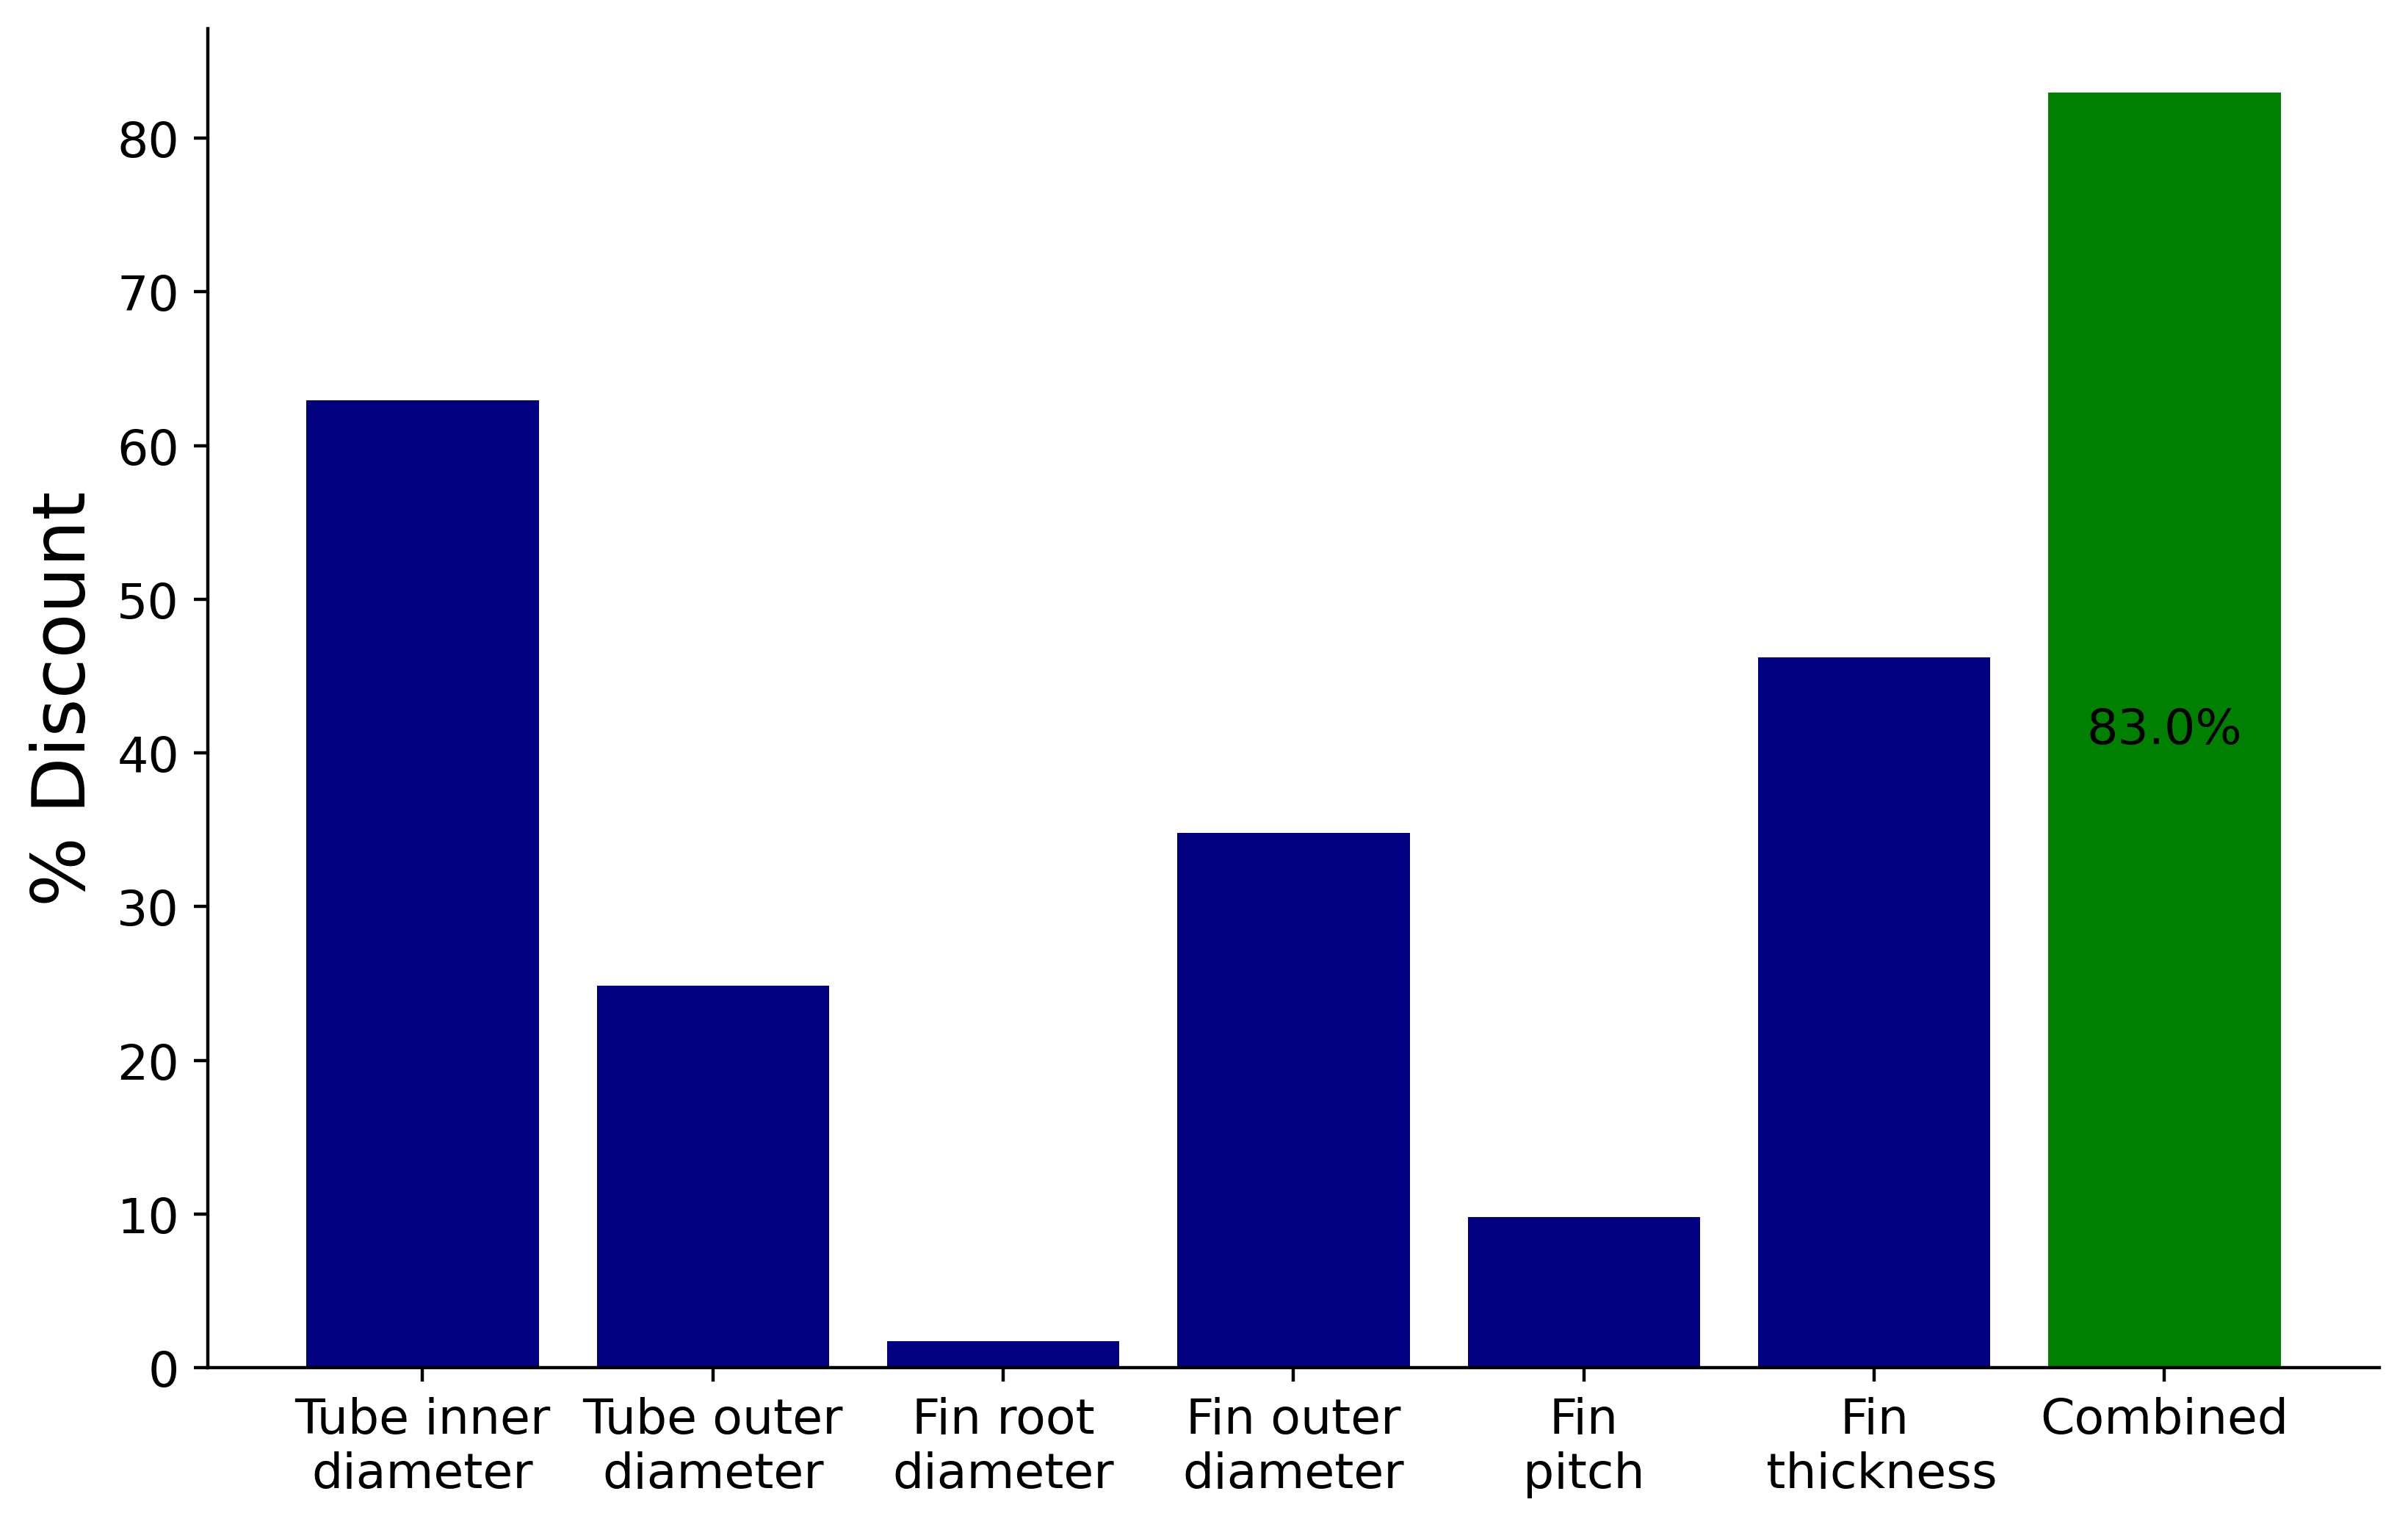

In [132]:
def savings(costs):
    return (cost_orig - np.array(costs))/ cost_orig * 100
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)
plt.bar(range(len(x_origin)), savings(costs), color="navy")
plt.bar(len(x_origin), savings(fX.min()), color="green")
plt.xticks(range(len(x_origin)+1), ["Tube inner\ndiameter", "Tube outer\ndiameter", "Fin root\ndiameter", "Fin outer\ndiameter",
"Fin\npitch", "Fin\n thickness", 
 "Combined"])
plt.ylabel("% Discount", fontsize=18)
ax.text(len(x_origin), savings(fX.min())/2, "{:.1f}%".format(savings(fX.min())), fontsize=12, ha='center', va='center')
# remove axes borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0.0)
fig.tight_layout(pad=0)
plt.savefig("savings.png")

# Parameter change percentage between original and optimal design

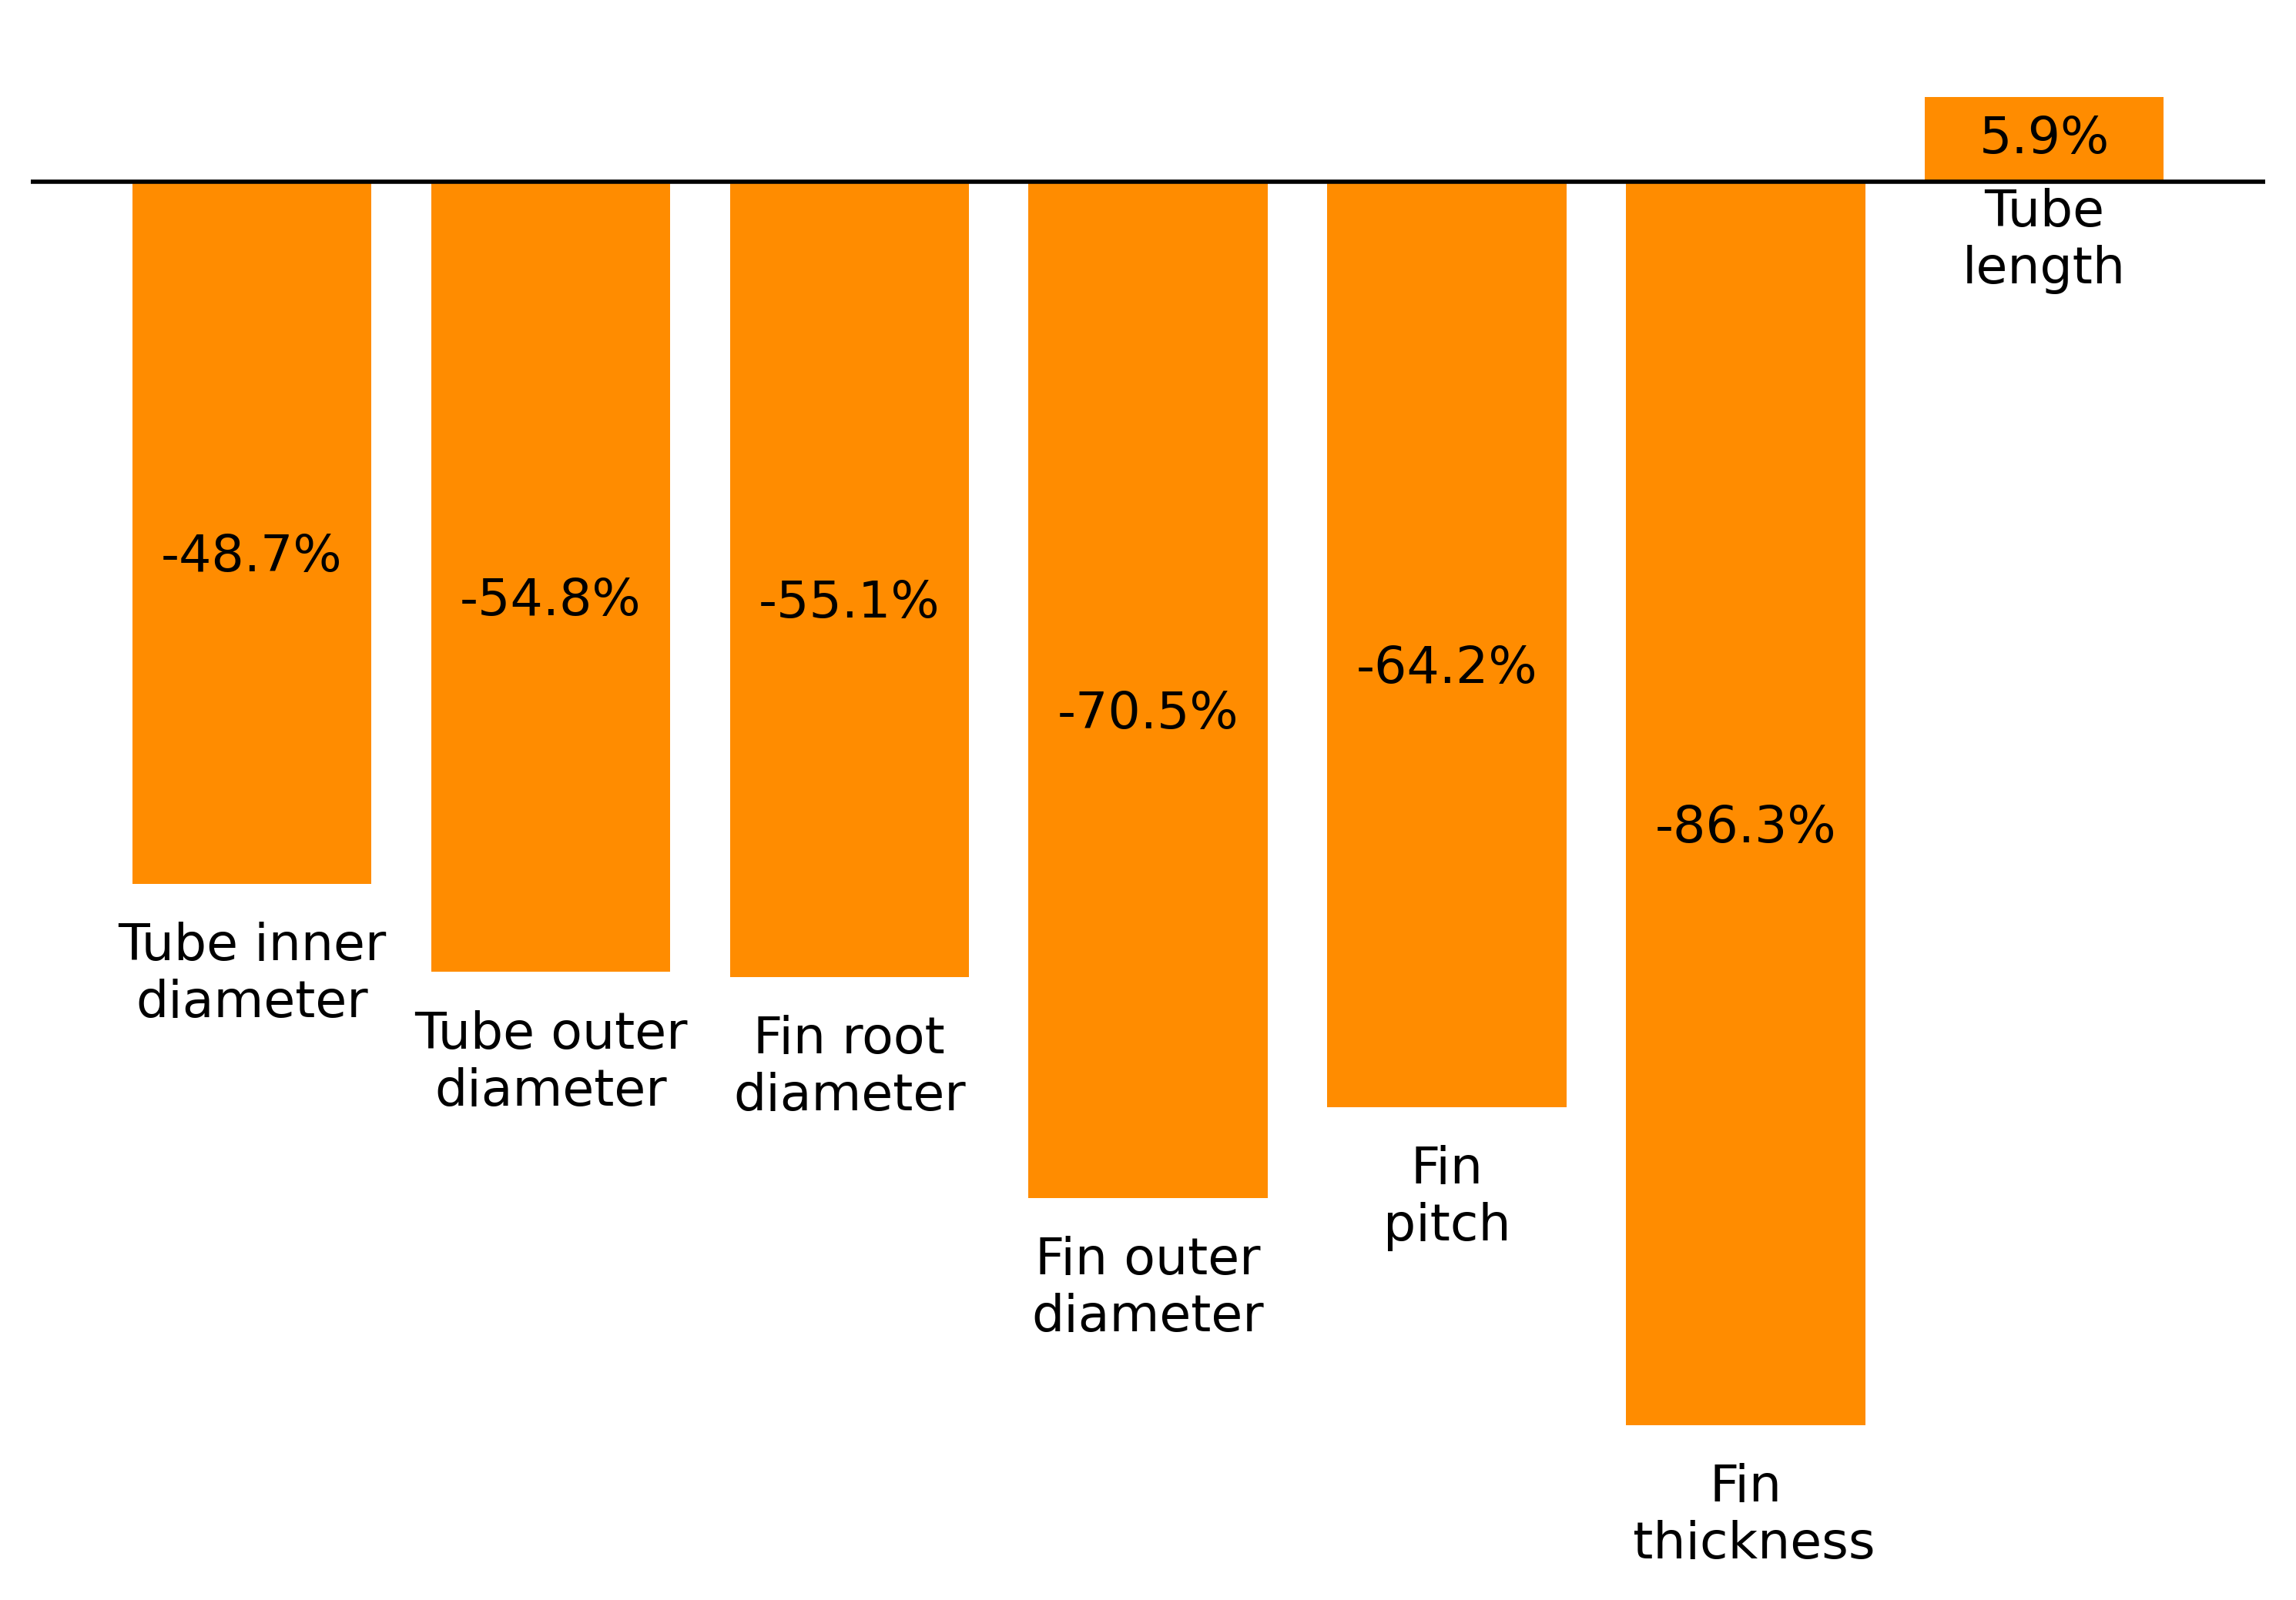

In [128]:
percent_diff = (x_best.cumprod() - x_origin.cumprod())/ x_origin.cumprod() * 100
def get_diffs(x):
    diffs0 = (x[:4].cumprod() - x_origin[:4].cumprod())/ x_origin[:4].cumprod() * 100 
    diffs1 = (x[4:].cumprod() - x_origin[4:].cumprod())/ x_origin[4:].cumprod() * 100
    return np.concatenate((diffs0, diffs1))


fig, ax = plt.subplots(figsize=(8, 5), dpi=400)
plt.bar(range(len(x_origin)), get_diffs(x_best), color="darkorange")
plt.bar(len(x_origin), (tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100 , color="darkorange")
# plt.xticks(range(len(x_origin)+1),["Tube inner\ndiameter", "Tube outer\ndiameter", "Fin root\ndiameter", "Fin outer\ndiameter",
# "Fin\npitch", "Fin\n thickness", 
#  "Tube\nlength"])
 # set text on top of bar
labels = ["Tube inner\ndiameter", "Tube outer\ndiameter", "Fin root\ndiameter", "Fin outer\ndiameter",
"Fin\npitch", "Fin\n thickness"]
for i, label in enumerate(labels):
    ax.text(i, get_diffs(x_best)[i] - 10, label, fontsize=12, ha='center', va='bottom')
    # add text to the bar
    ax.text(i, get_diffs(x_best)[i]/2, "{:.1f}%".format(get_diffs(x_best)[i]), fontsize=12, ha='center', va='top')
ax.text(len(x_origin), (tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100 - 10, "Tube\nlength", fontsize=12, ha='center', va='center')
ax.text(len(x_origin), (tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100/2, "{:.1f}%".format((tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100), fontsize=12, ha='center', va='center')

plt.ylabel("% channge", fontsize=18)
fig.tight_layout(pad=0)
ax.set_axis_off()
# # remove axes borders
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# # remove x axis
# ax.xaxis.set_visible(False)
# set transparent background
ax.patch.set_alpha(0.0)
plt.axhline(0, color="black", lw=1)
plt.savefig("changes.png")


In [95]:
x_best.cumprod()

array([1.02590278e-02, 1.12938971e-02, 1.25588080e-02, 1.68194371e-02,
       1.68708451e-05, 1.73356127e-06])

In [98]:
x_origin[4:].cumprod()

array([0.0028 , 0.00075])

In [134]:
def get_sim(x):
    tube_in_diameter = x[0]
    tube_out_diameter = tube_in_diameter * x[1]
    fin_in_diameter = tube_out_diameter  * x[2]
    fin_out_diameter = fin_in_diameter * x[3]
    fin_pitch = x[4]
    fin_thickness = fin_pitch * x[5]

    tube = Tube(
    tube_in_diameter=tube_in_diameter,
    tube_out_diameter=tube_out_diameter,
    fin_in_diameter=fin_in_diameter,
    fin_out_diameter=fin_out_diameter,
    fin_pitch=fin_pitch,
    fin_thickness=fin_thickness,
    )
    sim = DynamicLength(tube, verbose=0, n_rows=4, n_sub_shx=1, fast=False,)
    sim.run()
    tube.n_segments = sim.n_segments
    return sim

In [135]:
sim_best = get_sim(x_best)
sim_origin = get_sim(x_origin)

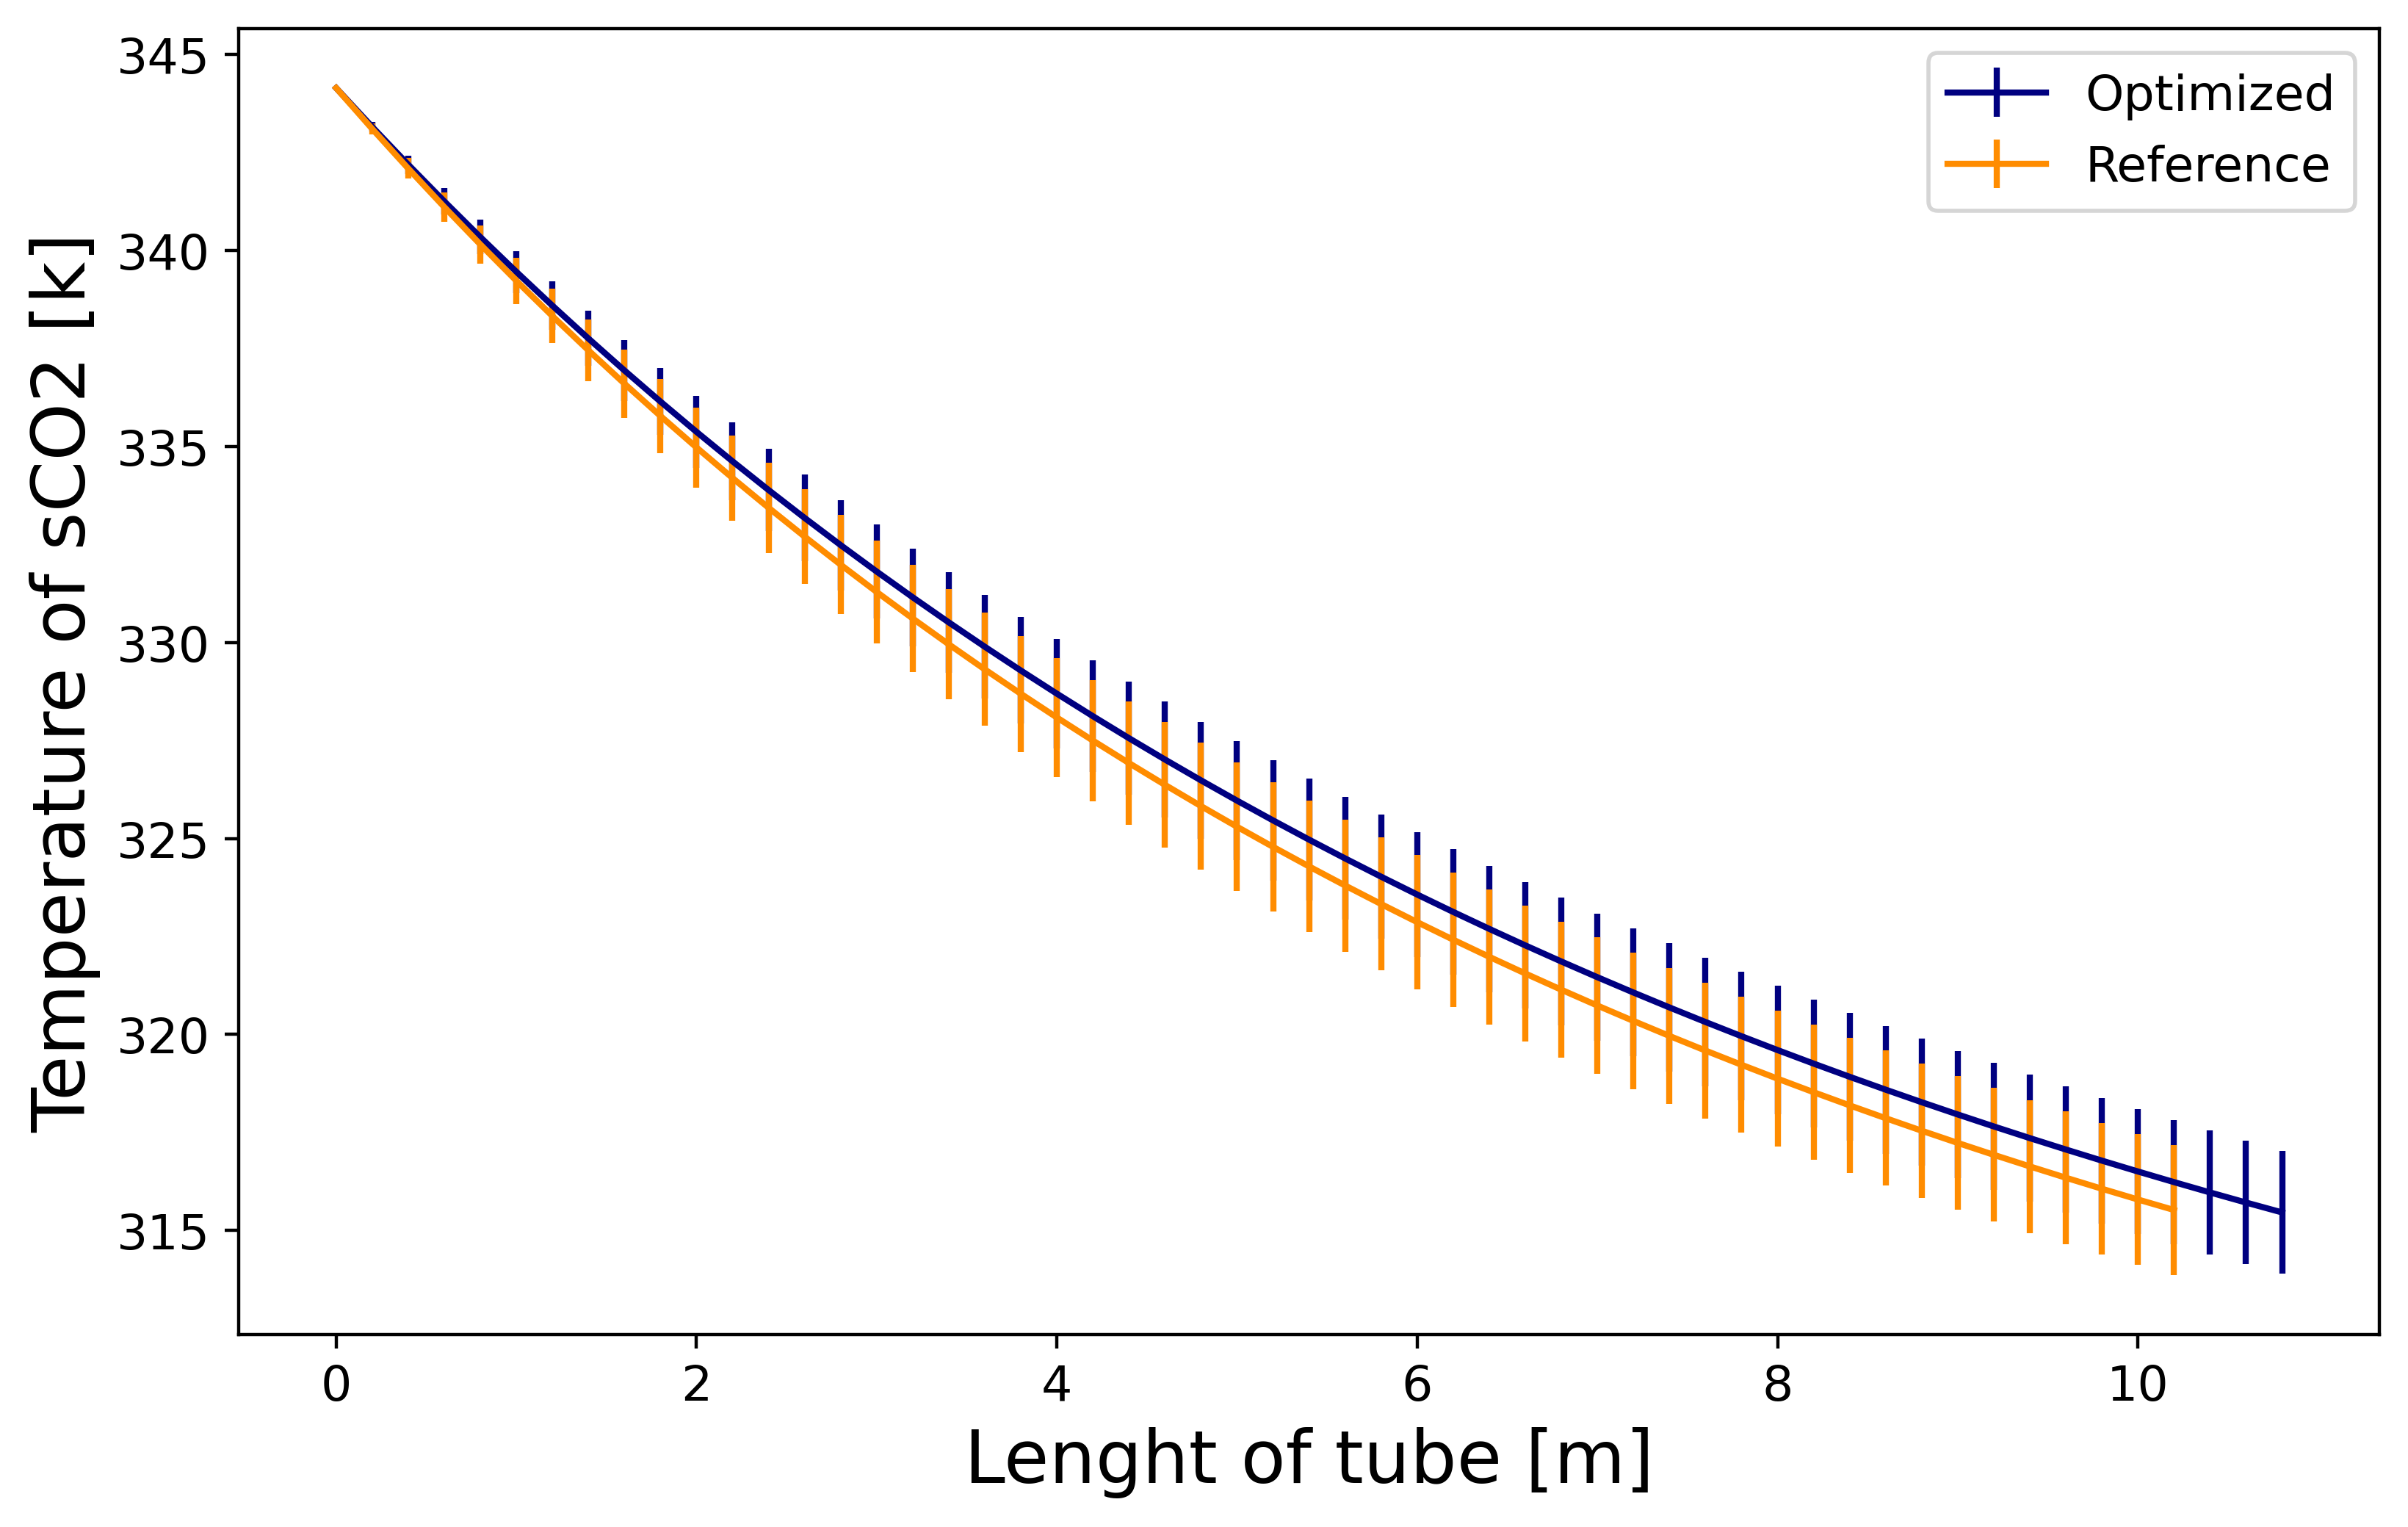

In [161]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)
means_best = np.mean(sim_best.results["t_co2"], axis=0)
means_origin = np.mean(sim_origin.results["t_co2"], axis=0)
stds_best = np.std(sim_best.results["t_co2"], axis=0)
stds_origin = np.std(sim_origin.results["t_co2"], axis=0)
plt.errorbar(np.linspace(0, sim_best.n_segments * tube_best.segment_length, len(means_best)), means_best, stds_best, color="navy", label="Optimized")
plt.errorbar(np.linspace(0, sim_origin.n_segments * tube_best.segment_length, len(means_origin)), means_origin, stds_origin, color="darkorange", label="Reference")
plt.legend()
plt.xlabel("Lenght of tube [m]", fontsize=18)
plt.ylabel("Temperature of sCO2 [k]", fontsize=18)
plt.tight_layout(pad=0)
ax.patch.set_alpha(0.0)
plt.savefig("sim.png")